# Using Time Series and Spend Data to Forecast Quarterly Trials

The below project is a modified version of an internal projection tool I created while working for a media agency. The tool takes assigned quarterly budgets per market and channel and uses the package Prophet to create three separate kinds timeseries forecasts (trend, flat trend, trend only used for fitting the model). 

Previously, mediabuyers used a best guess estimate for how changes in budget across tactics would impact the cost per conversion. The modeling effort seeks to make projections less time consuming by taking out guesswork and hopefully improve accuracy. For this reason, the model is compared primarily vs previous projections in terms of precisicion (how many markets did projections improve for) and accuracy (how did we do overall/for the larger markets).

The best model outperfromed mediabuyers estimates 70% of the time across two different quarters and was 15% closer to the actual number of observed trials. 

The outputs can be plugged into a dashboard and used with discretion by mediabuyers when considering individual tactics.

Data used is not reflective of client actuals.

## Setup Imports & Settings

In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import glob
import sqlalchemy as sqlalch
import pyodbc
import urllib

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings

#adjust max length and width for pandas; ignore warning prompts
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

In [2]:
import prophet

## Read & Prep Data

In [3]:
df = pd.read_csv(r'campaign_data.csv')

In [4]:
#set aside two quarters to compare forecasts to
df.Date = pd.to_datetime(df.Date)

FY21Q3 = df.loc[df.Date<'2021-04-01']
FY21Q3 = FY21Q3.loc[FY21Q3.Date>='2021-01-01']

FY21Q2 = df.loc[df.Date<'2021-01-01']
FY21Q2 = FY21Q2.loc[FY21Q2.Date>='2020-09-01']

In [5]:
mb_fcst = pd.read_excel(r'forecast.xlsx')


In [6]:
#read in media buyers' forecasts and create date fields for joining
import calendar
from calendar import monthrange
#mb_fcst = pd.read_excel(r'forecast.xlsx')
mb_fcst = mb_fcst.groupby(['Year','FY','Month','Market','Channel']).sum()[['Budget','fConversions']].reset_index()
d = dict((v,k) for k,v in enumerate(calendar.month_name))
mb_fcst['Month_Num'] = mb_fcst.Month.map(d)
mb_fcst['Day'] = 1
mb_fcst['Month_Start'] = pd.to_datetime(dict(year=mb_fcst.Year, month=mb_fcst.Month_Num, day=mb_fcst.Day))
mb_fcst['Month_Days'] = mb_fcst.Month_Start.dt.daysinmonth
mb_fcst['Est_Daily_Budget'] = mb_fcst['Budget']/mb_fcst['Month_Days']

## Create Formulas for Forecasts

In [7]:
import datetime

In [8]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [9]:
def create_ts_df(df, market, channel='none',pub='none',min='none',max='none'):
    dft = df.loc[df.Market ==market].reset_index(drop=True)
    if channel != 'none':
        dft = dft.loc[dft.Channel ==channel].reset_index(drop=True)
    if pub != 'none':
        dft = dft.loc[dft.Publisher ==pub].reset_index(drop=True)
    dft.Date = pd.to_datetime(dft.Date)
    dft = dft.groupby('Date').sum()[['Spend', 'Conversions']]
    dft = dft.reset_index()
    dft = dft.rename(columns={'Date':'ds','Conversions':'y','Spend':'spend'})
    dft = dft.loc[dft.ds<=max]
    dft = dft.loc[dft.ds>=min]
    dft = dft.reset_index(drop=True)
    return dft

In [10]:
def solve_mis_dates(df,yr,mon):
    year = yr
    months = mon
    num_m1_days = calendar.monthrange(year, months[0])[1]
    m1_days = pd.Series(pd.to_datetime([datetime.date(year, months[0], day) for day in range(1, num_m1_days+1)]))
    num_m2_days = calendar.monthrange(year, months[1])[1]
    m2_days = pd.Series(pd.to_datetime([datetime.date(year, months[1], day) for day in range(1, num_m2_days+1)]))
    num_m3_days = calendar.monthrange(year, months[2])[1]
    m3_days = pd.Series(pd.to_datetime([datetime.date(year, months[2], day) for day in range(1, num_m3_days+1)]))
    
    fyq_dates = pd.concat([m1_days, m2_days, m3_days])
    
    blanks = pd.DataFrame(fyq_dates)
    blanks.columns =['ds']
    blanks['spend'] = 0
    blanks['y'] = 0
    
    df = pd.concat([df,blanks]).groupby('ds').sum().reset_index()
    return df

In [11]:
from prophet import Prophet
def fit_ts_model(df, method='', daily_cap=100):
    m = Prophet(yearly_seasonality = True, growth=method)
    dft = df.reset_index(drop=True)
    dft['cap']= daily_cap
    m.add_regressor('spend')
    m.fit(dft)
    return m



In [12]:
def projected_spend(df = mb_fcst, chann = '', mar = ''):
    proj_spend = df.loc[df.Channel ==chann].reset_index(drop=True)
    proj_spend = proj_spend.loc[proj_spend.Market ==mar].reset_index(drop=True)
    return proj_spend

In [13]:
def project_trials(df, spend, model, per = 90, first_forecast_date=''):
    future = model.make_future_dataframe(periods=per)
    future['month'] = pd.DatetimeIndex(future['ds']).month
    future['year'] = pd.DatetimeIndex(future['ds']).year
    future = future.merge(spend[['Month_Num','Year','Est_Daily_Budget']], how='left',left_on= ['month','year'], right_on = ['Month_Num','Year'])
    future = future[['ds','Est_Daily_Budget']]
    future = future.rename(columns={'Est_Daily_Budget':'spend'})
    future.loc[future.ds<first_forecast_date,['spend']] = df.spend    
    future = future.fillna(0)
    fcst = model.predict(future)
    fcst['month'] = pd.DatetimeIndex(fcst['ds']).month
    fcst['year'] = pd.DatetimeIndex(fcst['ds']).year
    return fcst

In [14]:
def summarize_and_compare(model_proj, mb_proj, actuals, mar, chann, start='2021-01-01', end='2021-04,01'):

    #summarize model projections by month
    model_proj['month'] = pd.DatetimeIndex(model_proj['ds']).month
    model_proj['year'] = pd.DatetimeIndex(model_proj['ds']).year
    summary = model_proj.loc[df_proj.ds<=end]
    summary = summary.loc[df_proj.ds>=start]
    summary = summary[['year','month','yhat']].groupby(['year','month']).sum().reset_index()
    
    #summarize media buyers' projections by month
    mb_summary = mb_proj
    mb_summary['Month_Start'] = pd.to_datetime(mb_summary.Month_Start)
    mb_summary = mb_summary.loc[mb_summary.Month_Start<=end]
    mb_summary = mb_summary.loc[mb_summary.Month_Start>=start]
    mb_summary = mb_summary.loc[mb_summary.Channel ==chann].reset_index(drop=True)
    mb_summary = mb_summary.loc[mb_summary.Market ==mar].reset_index(drop=True)
    mb_summary = mb_summary[['Year','Month_Num','fConversions','Budget']].groupby(['Year','Month_Num']).sum().reset_index() 
    mb_summary = mb_summary.rename(columns={'Month_Num':'month','Year':'year','fConversions':'mb_trial_forecast','Budget':'mb_budget'})
    
    #summarize actuals by month
    actuals_summary = actuals.loc[actuals.Market ==mar].reset_index(drop=True)
    actuals_summary = actuals_summary.loc[actuals_summary.Channel ==chann].reset_index(drop=True)
    actuals_summary['month'] = pd.DatetimeIndex(actuals_summary['Date']).month
    actuals_summary['year'] = pd.DatetimeIndex(actuals_summary['Date']).year
    actuals_summary = actuals_summary[['year','month','Conversions','Spend']].groupby(['year','month']).sum().reset_index()
    actuals_summary = actuals_summary.rename(columns={'Conversions':'actual_trials','Spend':'actual_spend'})
    
    #join all summaries to one table
    full_summ = summary.merge(mb_summary, how='left',left_on= ['month','year'], right_on = ['month','year'])
    full_summ = full_summ.merge(actuals_summary, how='left',left_on= ['month','year'], right_on = ['month','year'])
    full_summ = full_summ.rename(columns={'yhat':'model_trial_forecast'})
    full_summ['market'] = mar
    full_summ['channel'] = chann

    return full_summ

## Create Market and Channel Lists

In [15]:
channels = ['Display', 'Social']

In [16]:
markets = df[['Market','Spend']].groupby('Market').sum().sort_values('Spend',ascending=False).reset_index()['Market'][0:10].to_list()

## FY2021 Q3 Forecast - Linear Growth & No Growth Trends

In [17]:
summ_cols = ['year','month','model_trial_forecast','mb_trial_forecast','mb_budget','actual_trials','actual_spend','market','channel']

In [18]:
proj_cols = ['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'extra_regressors_additive', 'extra_regressors_additive_lower', 'extra_regressors_additive_upper', 'spend', 'spend_lower', 'spend_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat','month','year','market','channel']

In [19]:
summ_q3_lin = pd.DataFrame(columns=summ_cols)
q3_lin_fcst = pd.DataFrame(columns=proj_cols)
summ_q3_rec = pd.DataFrame(columns=summ_cols)
q3_rec_fcst = pd.DataFrame(columns=proj_cols)


In [20]:
for mar in markets:
    for chann in channels:
        if mar == 'Japan' and chann == 'Social': continue 
        dft = create_ts_df(df, mar,chann, min='2018-01-01',max='2020-12-31') #create timeseries data frame
        m = fit_ts_model(dft, method='linear',daily_cap=100) #fit model using prophet timeseries package
        spend_proj = projected_spend(mb_fcst, chann, mar) #get media buyers' spend projections per market and channel
        df_proj = project_trials(dft, spend_proj, m, 90, '2021-01-01') #project trials using timeseries model w/ additional spend regressor
        df_proj['market'] = mar
        df_proj['channel'] = chann
        q3_lin_fcst = pd.concat([q3_lin_fcst, df_proj], ignore_index = True)
        summ = summarize_and_compare(df_proj, mb_fcst, FY21Q3, mar, chann, '2021-01-01', '2021-03-31') #compare model forecast to actuals and media buyers' forecasts
        summ_q3_lin = pd.concat([summ_q3_lin, summ], ignore_index = True)
        df_rec = df_proj.copy()
        df_rec.loc[(df_rec.ds >= '2021-01-01') & (df_rec.ds <= '2021-03-31'),'trend'] = df_rec.loc[(df_rec.month == 12) & (df_rec.year == 2020),'trend'].mean()
        df_rec['yhat'] = (df_rec.trend + df_rec.spend + df_rec.weekly +df_rec.yearly)
        summ2 = summarize_and_compare(df_rec, mb_fcst, FY21Q3, mar, chann, '2021-01-01', '2021-03-31') #compare model forecast to actuals and media buyers' forecasts
        summ_q3_rec = pd.concat([summ_q3_rec, summ2], ignore_index = True)
        q3_rec_fcst = pd.concat([q3_rec_fcst, df_rec], ignore_index = True)
summ_q3_lin['forecast'] = 'FYQ321 - Linear'
q3_lin_fcst['forecast'] = 'FYQ321 - Linear'
summ_q3_rec['forecast'] = 'FYQ321 - Recency'
q3_rec_fcst['forecast'] = 'FYQ321 - Recency'    

In [21]:
summ_q3_flat = pd.DataFrame(columns=summ_cols) 
q3_flat_fcst = pd.DataFrame(columns=proj_cols)

In [22]:
for mar in markets:
    for chann in channels:
        if mar == 'Japan' and chann == 'Social': continue 
        dft = create_ts_df(df, mar,chann, min='2018-01-01',max='2020-12-31') #create timeseries data frame
        m = fit_ts_model(dft, method='flat',daily_cap=100) #fit model using prophet timeseries package
        spend_proj = projected_spend(mb_fcst, chann, mar) #get media buyers' spend projections per market and channel
        df_proj = project_trials(dft, spend_proj, m, 90, '2021-01-01') #project trials using timeseries model w/ additional spend regressor
        df_proj['market'] = mar
        df_proj['channel'] = chann
        q3_flat_fcst = pd.concat([q3_flat_fcst, df_proj], ignore_index = True)
        summ = summarize_and_compare(df_proj, mb_fcst, FY21Q3, mar, chann, '2021-01-01', '2021-03-31') #compare model forecast to actuals and media buyers' forecasts
        summ_q3_flat = pd.concat([summ_q3_flat, summ], ignore_index = True)
summ_q3_flat['forecast'] = 'FYQ321 - Flat'   
q3_flat_fcst['forecast'] = 'FYQ321 - Flat'         

## FY2021 Q2 Forecast - Linear Growth & Flat Growth Trends

In [23]:
summ_q2_lin = pd.DataFrame(columns=summ_cols) 
q2_lin_fcst = pd.DataFrame(columns=proj_cols)
summ_q2_rec = pd.DataFrame(columns=summ_cols)
q2_rec_fcst = pd.DataFrame(columns=proj_cols)

In [24]:
for mar in markets:
    for chann in channels:
        dft = create_ts_df(df, mar,chann, min='2018-01-01',max='2020-09-30') #create timeseries data frame
        m = fit_ts_model(dft, method='linear') #fit model using prophet timeseries package
        spend_proj = projected_spend(mb_fcst, chann, mar) #get media buyers' spend projections per market and channel
        df_proj = project_trials(dft, spend_proj, m, 90, '2020-10-01') #project trials using timeseries model w/ additional spend regressor
        df_proj['market'] = mar
        df_proj['channel'] = chann
        q2_lin_fcst = pd.concat([q2_lin_fcst, df_proj], ignore_index = True)
        summ = summarize_and_compare(df_proj, mb_fcst, FY21Q2, mar, chann, '2020-10-01', '2020-12-31') #compare model forecast to actuals and media buyers' forecasts
        summ_q2_lin = pd.concat([summ_q2_lin, summ], ignore_index = True)
        df_rec = df_proj.copy()
        df_rec.loc[(df_rec.ds >= '2020-10-01') & (df_rec.ds <= '2020-12-31'),'trend'] = df_rec.loc[(df_rec.month == 9) & (df_rec.year == 2020),'trend'].mean()
        df_rec['yhat'] = (df_rec.trend + df_rec.spend + df_rec.weekly +df_rec.yearly)
        summ2 = summarize_and_compare(df_rec, mb_fcst, FY21Q2, mar, chann, '2020-10-01', '2020-12-31') #compare model forecast to actuals and media buyers' forecasts
        summ_q2_rec = pd.concat([summ_q2_rec, summ2], ignore_index = True)
        q2_rec_fcst = pd.concat([q2_rec_fcst, df_rec], ignore_index = True)
summ_q2_lin['forecast'] = 'FYQ221 - Linear' 
q2_lin_fcst['forecast'] = 'FYQ221 - Linear'        
summ_q2_rec['forecast'] = 'FYQ221 - Recency'
q2_rec_fcst['forecast'] = 'FYQ221 - Recency'  

In [25]:
df_rec.loc[(df_rec.month == 9) & (df_rec.year == 2020),'trend'].mean()


0.8902058795224465

In [26]:
summ_q2_flat = pd.DataFrame(columns=summ_cols) 
q2_flat_fcst = pd.DataFrame(columns=proj_cols)

In [27]:
for mar in markets:
    for chann in channels:
        dft = create_ts_df(df, mar,chann, min='2018-01-01',max='2020-09-30') #create timeseries data frame
        m = fit_ts_model(dft, method='flat') #fit model using prophet timeseries package
        spend_proj = projected_spend(mb_fcst, chann, mar) #get media buyers' spend projections per market and channel
        df_proj = project_trials(dft, spend_proj, m, 90, '2020-10-01') #project trials using timeseries model w/ additional spend regressor
        df_proj['market'] = mar
        df_proj['channel'] = chann
        q2_flat_fcst = pd.concat([q2_flat_fcst, df_proj], ignore_index = True)
        summ = summarize_and_compare(df_proj, mb_fcst, FY21Q2, mar, chann, '2020-10-01', '2020-12-31') #compare model forecast to actuals and media buyers' forecasts
        summ_q2_flat = pd.concat([summ_q2_flat, summ], ignore_index = True)
summ_q2_flat['forecast'] = 'FYQ221 - Flat' 
q2_flat_fcst['forecast'] = 'FYQ221 - Flat'         

## High Level Evaluation

In [28]:
#combine all forecasts
summ_all = pd.concat([summ_q2_lin, summ_q2_flat, summ_q3_lin, summ_q3_flat, summ_q2_rec, summ_q3_rec], ignore_index=True)
fcst_details = pd.concat([q2_flat_fcst, q2_lin_fcst, q3_flat_fcst, q3_lin_fcst, q2_rec_fcst, q3_rec_fcst], ignore_index=True)

In [29]:
#create formulas to compare model forecast to media buyer forecasts 
summ_all['model_percent_diff'] = (summ_all.model_trial_forecast - summ_all.actual_trials )/ summ_all.actual_trials
summ_all['mb_percent_diff'] = (summ_all.mb_trial_forecast - summ_all.actual_trials )/ summ_all.actual_trials
summ_all['model_trial_diff'] = summ_all.model_trial_forecast - summ_all.actual_trials
summ_all['mb_trial_diff'] = summ_all.mb_trial_forecast - summ_all.actual_trials

In [30]:
#summarize by market
summ_all_market = summ_all[['forecast','market','model_trial_forecast','mb_trial_forecast','actual_trials','model_trial_diff', 'mb_trial_diff']].groupby(['forecast','market']).sum().reset_index()
summ_all_market['model_percent_diff'] = (summ_all_market.model_trial_forecast - summ_all_market.actual_trials )/ summ_all_market.actual_trials
summ_all_market['mb_percent_diff'] = (summ_all_market.mb_trial_forecast - summ_all_market.actual_trials )/ summ_all_market.actual_trials
summ_all_market['model_percent_diff'] = (summ_all_market.model_trial_forecast - summ_all_market.actual_trials )/ summ_all_market.actual_trials
summ_all_market['mb_percent_diff'] = (summ_all_market.mb_trial_forecast - summ_all_market.actual_trials )/ summ_all_market.actual_trials
summ_all_market['beats_mb_forecast'] = summ_all_market.model_percent_diff.abs() < summ_all_market.mb_percent_diff.abs()

In [31]:
#summarize by forecast
fcst_summ = summ_all_market.groupby(['forecast']).sum()
fcst_summ['total mb % off in trials'] = (fcst_summ.mb_trial_forecast - fcst_summ.actual_trials).abs()/fcst_summ.actual_trials
fcst_summ['total model % off in trials'] = (fcst_summ.model_trial_forecast - fcst_summ.actual_trials).abs()/fcst_summ.actual_trials

Overall the model appears to give a more precise prediction with the flat forecast beating the mb forecast 70% of the time and the trend 
forecasts beating the media buyer forecast 55% of the time. Accuracy is also near or better using the timeseries model.

Between models, it's difficult to determine whether using a flat model or trend model is appropriate. The question may more appropriately fall upon the media buyer to answer what may cause the trend (such as increased competition, changes in bid strategy, etc.) 


In [32]:
fcst_summ[['beats_mb_forecast','total model % off in trials', 'total mb % off in trials']]

,beats_mb_forecast,total model % off in trials,total mb % off in trials
forecast,,,
FYQ221 - Flat,7,0.125967,0.234540
FYQ221 - Linear,4,0.323830,0.234540
FYQ221 - Recency,4,0.310773,0.234540
FYQ321 - Flat,7,0.128836,0.087279
FYQ321 - Linear,7,0.038151,0.087279
FYQ321 - Recency,8,0.085050,0.087279


In [33]:
summ_all_market['percent better than mb forecast'] = summ_all_market.mb_percent_diff.abs() - summ_all_market.model_percent_diff.abs()

The model was generally within or near 20% off or better than the media buyers forecasts, with Market 6 being the exception.

In [34]:
pd.pivot_table(summ_all_market, values=['percent better than mb forecast'], index=["market"], columns=["forecast"], margins = True)

percent better than mb forecast                                                                                          
forecast                    FYQ221 - Flat FYQ221 - Linear FYQ221 - Recency FYQ321 - Flat FYQ321 - Linear FYQ321 - Recency       All
market                                                                                                                             
Market 1                         0.171659       -0.271085        -0.252544      0.070423       -0.021266        -0.067786 -0.061766
Market 10                        0.156457       -0.036304        -0.019001      0.208319        0.112917         0.149539  0.095321
Market 2                         0.077441        0.043211         0.027286      0.041946        0.023145         0.063948  0.046163
Market 3                         0.327737       -0.172878        -0.104717      0.066640        0.040519         0.020000  0.029550
Market 4                         0.132002       -0.177639        -0.120158      0.107869        0.113540         0.081055  0.022778
Market 5                        -0.077557        0.231043         0.208688      0.012978       -0.024422         0.003864  0.059099
Market 6                        -0.582298       -0.215801        -0.252914     -0.408447        0.079706         0.016380 -0.227229
Market 7                         0.095894       -0.227223        -0.191196      0.010442        0.046550         0.046041 -0.036582
Market 8                         0.245613        0.180543         0.172201     -0.047640        0.085490         0.053648  0.114976
Market 9                        -0.001060        0.066324         0.074296     -0.112339       -0.105815        -0.142039 -0.036772
All                              0.054589       -0.057981        -0.045806     -0.004981        0.035036         0.022465  0.000554

Markets 1, 6, and 9 were hardest to predict when looking at all model scores. Markets 6 and 9 had the lowest volume of trials, which likely had an influence.

In [35]:
pd.pivot_table(summ_all_market, values=['actual_trials','beats_mb_forecast'], index=["market"], columns=["forecast"],margins=True).iloc[:,6:]

actual_trials beats_mb_forecast                                                                                          
forecast            All     FYQ221 - Flat FYQ221 - Linear FYQ221 - Recency FYQ321 - Flat FYQ321 - Linear FYQ321 - Recency       All
market                                                                                                                             
Market 1        749.000               1.0             0.0              0.0           1.0             0.0              0.0  0.333333
Market 10       245.500               1.0             0.0              0.0           1.0             1.0              1.0  0.666667
Market 2        925.125               1.0             1.0              1.0           1.0             1.0              1.0  1.000000
Market 3        178.250               1.0             0.0              0.0           1.0             1.0              1.0  0.666667
Market 4        457.875               1.0             0.0              0.0           1.0             1.0              1.0  0.666667
Market 5        425.875               0.0             1.0              1.0           1.0             0.0              1.0  0.666667
Market 6        644.125               0.0             0.0              0.0           0.0             1.0              1.0  0.333333
Market 7       1504.375               1.0             0.0              0.0           1.0             1.0              1.0  0.666667
Market 8       1102.450               1.0             1.0              1.0           0.0             1.0              1.0  0.833333
Market 9        236.125               0.0             1.0              1.0           0.0             0.0              0.0  0.333333
All             646.870               0.7             0.4              0.4           0.7             0.7              0.8  0.616667

For Social, Market 6 had a gap in data and a high October spike in conversions. Given the historical data is only 1 year, it's unlikely a similar spike should be expected again and projections for the month could be lowered.

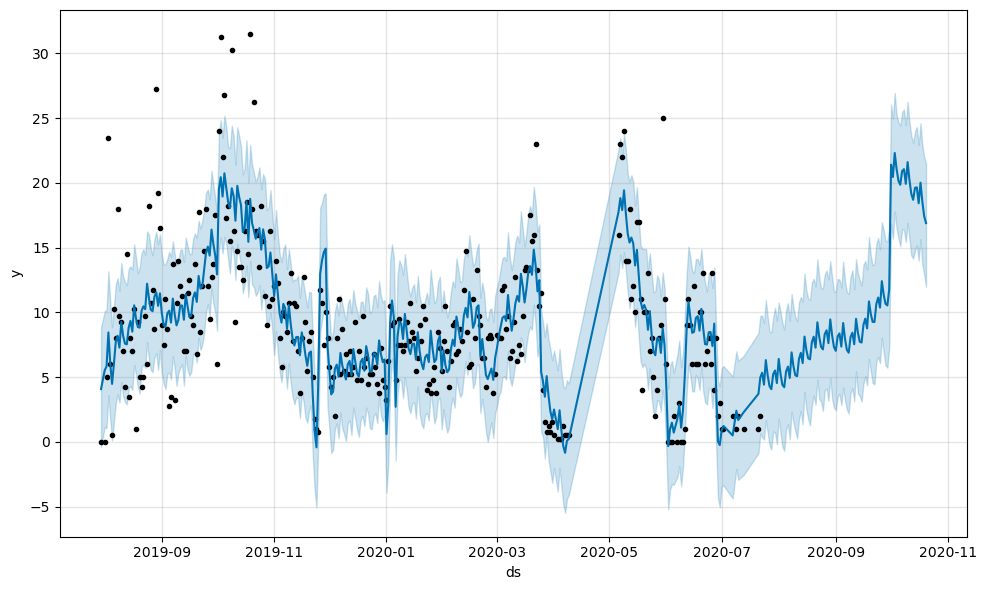

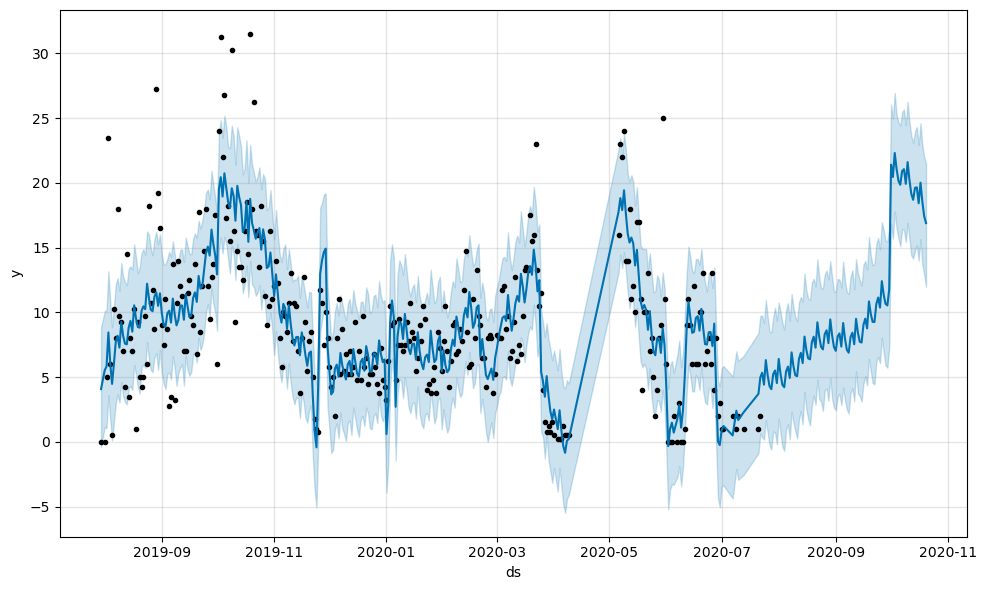

In [36]:
dft = create_ts_df(df, 'Market 6','Social', min='2018-01-01',max='2020-09-30') #create timeseries data frame
m = fit_ts_model(dft, method='flat') #fit model using prophet timeseries package

m.plot(fcst_details.loc[(fcst_details.market == 'Market 6' )& (fcst_details.forecast == 'FYQ221 - Flat')& (fcst_details.channel == 'Social')].reset_index(drop=True))

In [37]:
fcst_details.loc[(fcst_details.market == 'Market 8' )& (fcst_details.forecast == 'FYQ221 - Linear')& (fcst_details.channel == 'Social')]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,spend,spend_lower,spend_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,month,year,market,channel,forecast
17996,2018-02-09,3.654300,0.757158,3.258543,3.654300,3.654300,-1.686259,-1.686259,-1.686259,-1.703190,-1.703190,-1.703190,-1.703190,-1.703190,-1.703190,-0.094618,-0.094618,-0.094618,0.111549,0.111549,0.111549,0.0,0.0,0.0,1.968041,2,2018,Market 8,Social,FYQ221 - Linear
17997,2018-02-12,3.629121,0.601601,3.109982,3.629121,3.629121,-1.719455,-1.719455,-1.719455,-1.703190,-1.703190,-1.703190,-1.703190,-1.703190,-1.703190,-0.112346,-0.112346,-0.112346,0.096080,0.096080,0.096080,0.0,0.0,0.0,1.909666,2,2018,Market 8,Social,FYQ221 - Linear
17998,2018-02-13,3.620728,0.858893,3.326526,3.620728,3.620728,-1.522426,-1.522426,-1.522426,-1.703190,-1.703190,-1.703190,-1.703190,-1.703190,-1.703190,0.086252,0.086252,0.086252,0.094511,0.094511,0.094511,0.0,0.0,0.0,2.098302,2,2018,Market 8,Social,FYQ221 - Linear
17999,2018-02-20,3.561978,1.441122,4.043275,3.561978,3.561978,-0.832734,-0.832734,-0.832734,-1.039151,-1.039151,-1.039151,-1.039151,-1.039151,-1.039151,0.086252,0.086252,0.086252,0.120165,0.120165,0.120165,0.0,0.0,0.0,2.729244,2,2018,Market 8,Social,FYQ221 - Linear
18000,2018-02-21,3.553585,1.291087,3.891140,3.553585,3.553585,-0.945189,-0.945189,-0.945189,-1.164247,-1.164247,-1.164247,-1.164247,-1.164247,-1.164247,0.092124,0.092124,0.092124,0.126934,0.126934,0.126934,0.0,0.0,0.0,2.608396,2,2018,Market 8,Social,FYQ221 - Linear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19010,2020-12-25,1.934970,-0.076053,2.483979,1.852032,2.019861,-0.734802,-0.734802,-0.734802,0.107371,0.107371,0.107371,0.107371,0.107371,0.107371,-0.094618,-0.094618,-0.094618,-0.747556,-0.747556,-0.747556,0.0,0.0,0.0,1.200168,12,2020,Market 8,Social,FYQ221 - Linear
19011,2020-12-26,1.932687,0.105636,2.625546,1.848159,2.018928,-0.602276,-0.602276,-0.602276,0.107371,0.107371,0.107371,0.107371,0.107371,0.107371,-0.028721,-0.028721,-0.028721,-0.680927,-0.680927,-0.680927,0.0,0.0,0.0,1.330411,12,2020,Market 8,Social,FYQ221 - Linear
19012,2020-12-27,1.930405,0.246257,2.858487,1.844389,2.017994,-0.458111,-0.458111,-0.458111,0.107371,0.107371,0.107371,0.107371,0.107371,0.107371,0.045507,0.045507,0.045507,-0.610989,-0.610989,-0.610989,0.0,0.0,0.0,1.472294,12,2020,Market 8,Social,FYQ221 - Linear
19013,2020-12-28,1.928122,0.019752,2.670412,1.840797,2.017016,-0.543457,-0.543457,-0.543457,0.107371,0.107371,0.107371,0.107371,0.107371,0.107371,-0.112346,-0.112346,-0.112346,-0.538483,-0.538483,-0.538483,0.0,0.0,0.0,1.384664,12,2020,Market 8,Social,FYQ221 - Linear


In [38]:
all_proj_inputs = fcst_details[['forecast','market','channel','year','month','yhat','trend','spend','weekly','yearly']]

In [39]:
all_proj_inputs = all_proj_inputs.groupby(['forecast','market','channel','year','month']).sum().reset_index()

Below are the model inputs that can be reviewed by media buyers to assist in finalizing total conversion forecasts. 

Visuals can be recreated in a dashboard and the multipliers can be provided in Excel.

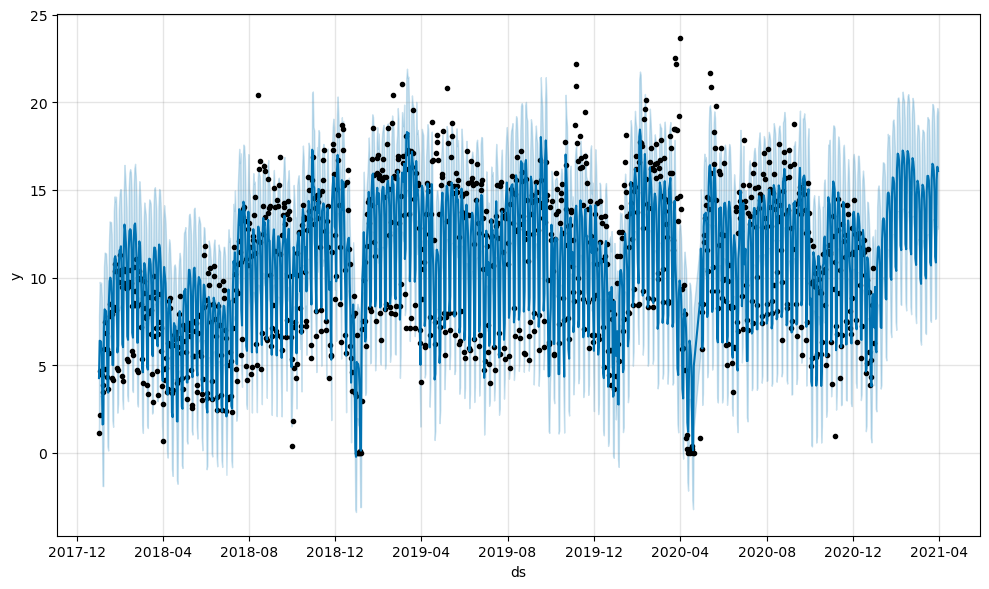

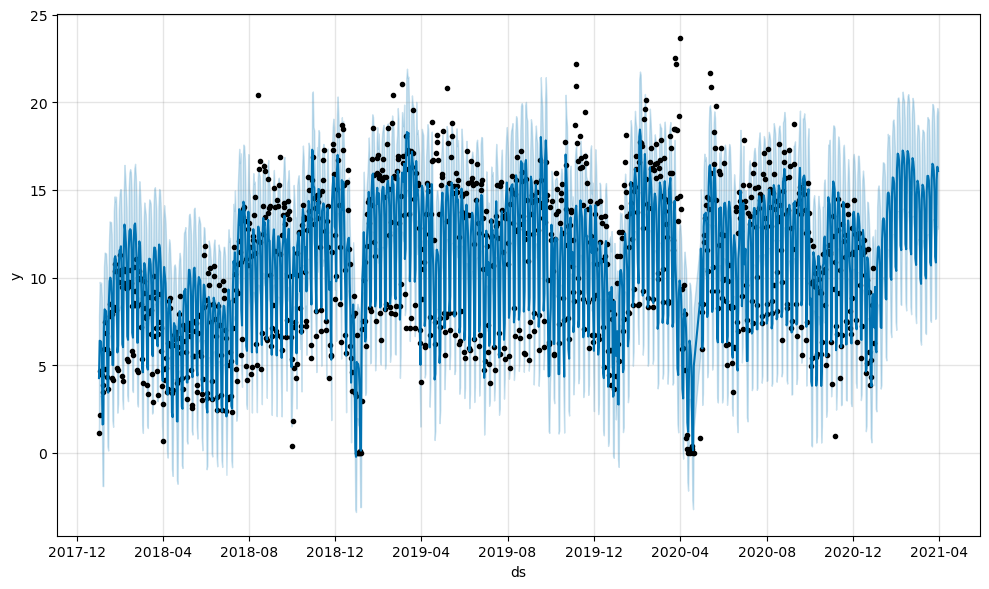

In [40]:
dft = create_ts_df(df, 'Market 8','Display', min='2018-01-01',max='2020-12-31') #create timeseries data frame
m = fit_ts_model(dft, method='flat') #fit model using prophet timeseries package

m.plot(fcst_details.loc[(fcst_details.market == 'Market 8' )& (fcst_details.forecast == 'FYQ321 - Flat')& (fcst_details.channel == 'Display')].reset_index(drop=True))

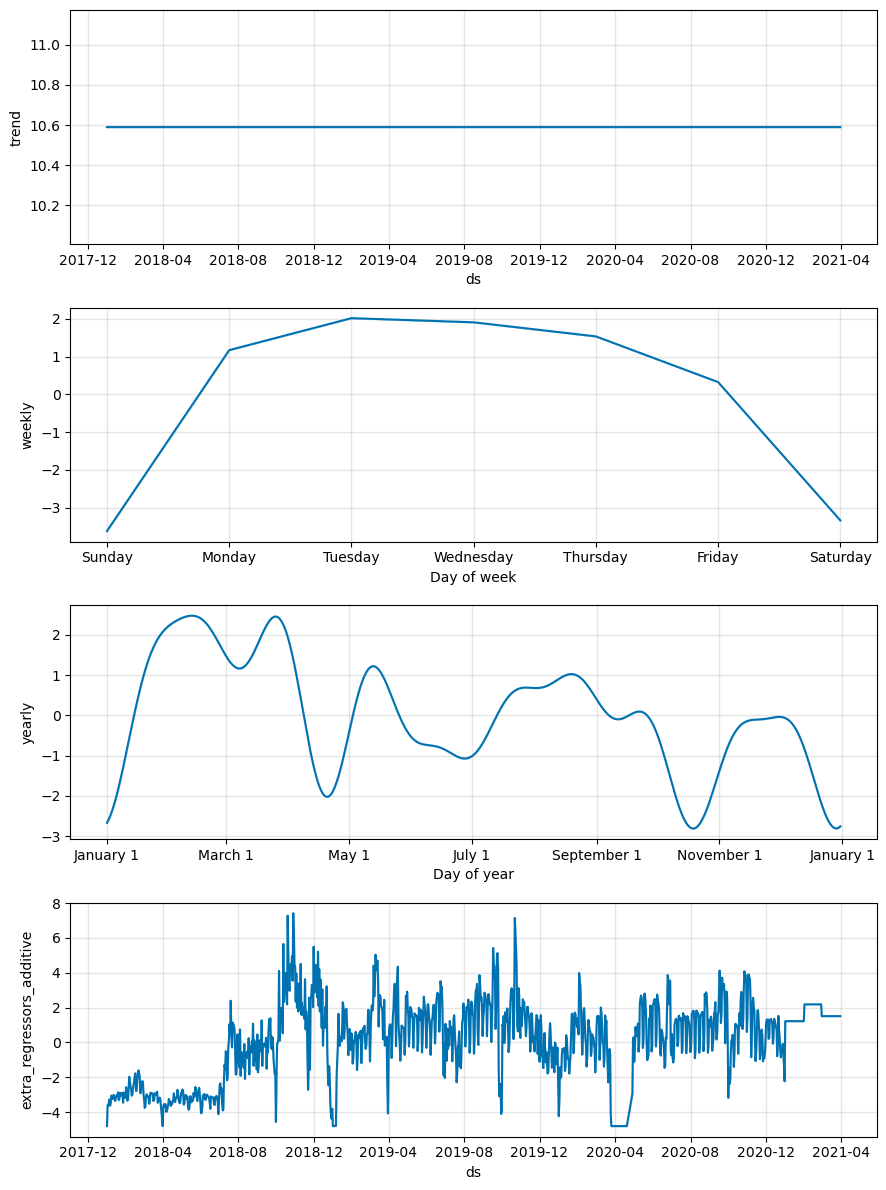

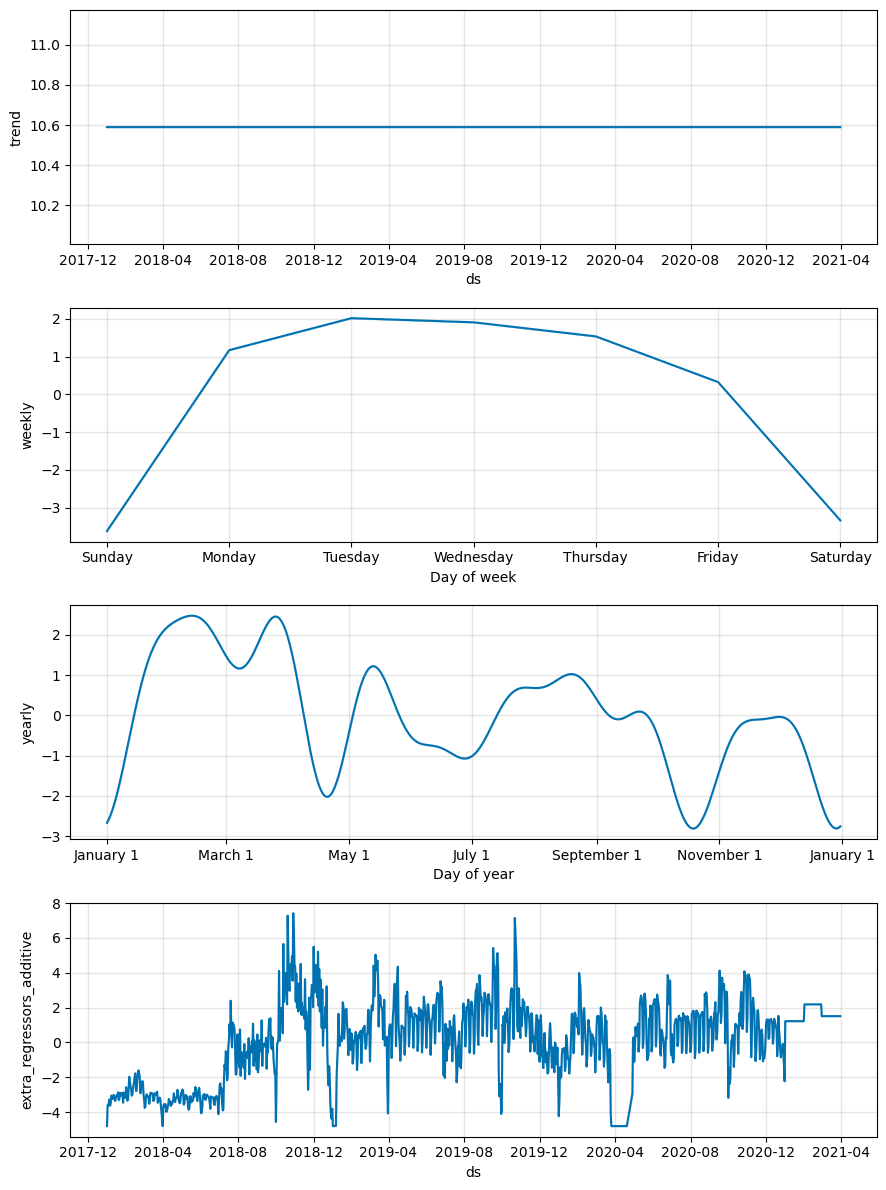

In [41]:
m.plot_components(fcst_details.loc[(fcst_details.market == 'Market 8' )& (fcst_details.forecast == 'FYQ321 - Flat')& (fcst_details.channel == 'Display')].reset_index(drop=True))

In [42]:
all_proj_inputs.loc[(all_proj_inputs.market == 'Market 8' )&(all_proj_inputs.forecast == 'FYQ321 - Flat')& (all_proj_inputs.channel == 'Display')].tail()

,forecast,market,channel,year,month,yhat,trend,spend,weekly,yearly
2304,FYQ321 - Flat,Market 8,Display,2020,11,333.692565,317.692815,28.236003,-2.452527e+00,-9.783726
2305,FYQ321 - Flat,Market 8,Display,2020,12,302.895139,328.282576,12.154511,5.467373e+00,-43.009321
2306,FYQ321 - Flat,Market 8,Display,2021,1,361.840358,328.282576,37.829125,-6.639504e+00,2.368161
2307,FYQ321 - Flat,Market 8,Display,2021,2,420.407630,296.513294,61.193600,-6.959766e-12,62.700736
2308,FYQ321 - Flat,Market 8,Display,2021,3,434.835813,328.282576,46.787827,5.102644e+00,54.662766


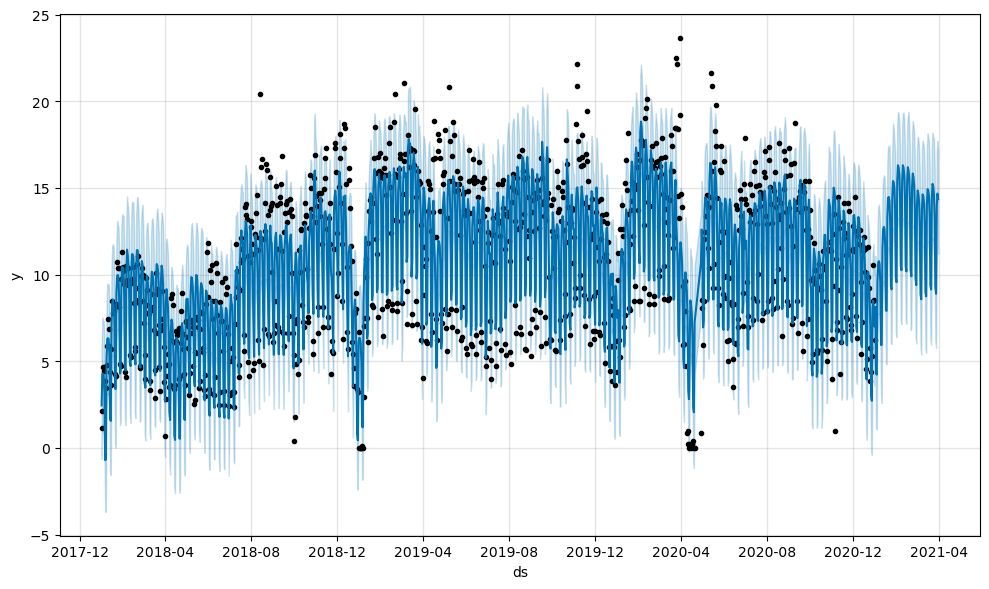

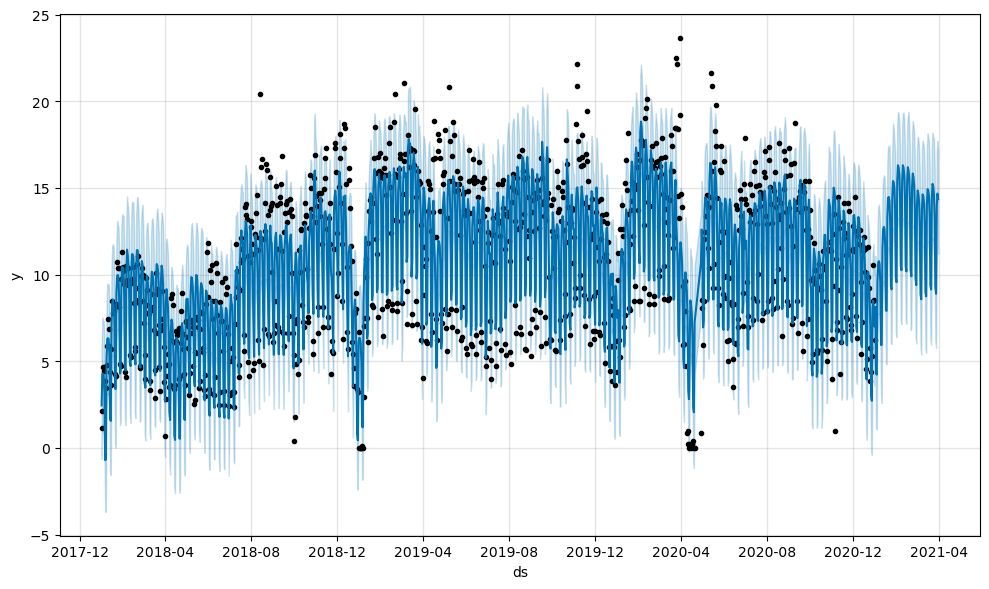

In [43]:
dft = create_ts_df(df, 'Market 8','Display', min='2018-01-01',max='2020-12-31') #create timeseries data frame
m = fit_ts_model(dft, method='linear') #fit model using prophet timeseries package

m.plot(fcst_details.loc[(fcst_details.market == 'Market 8' )& (fcst_details.forecast == 'FYQ321 - Linear')& (fcst_details.channel == 'Display')].reset_index(drop=True))

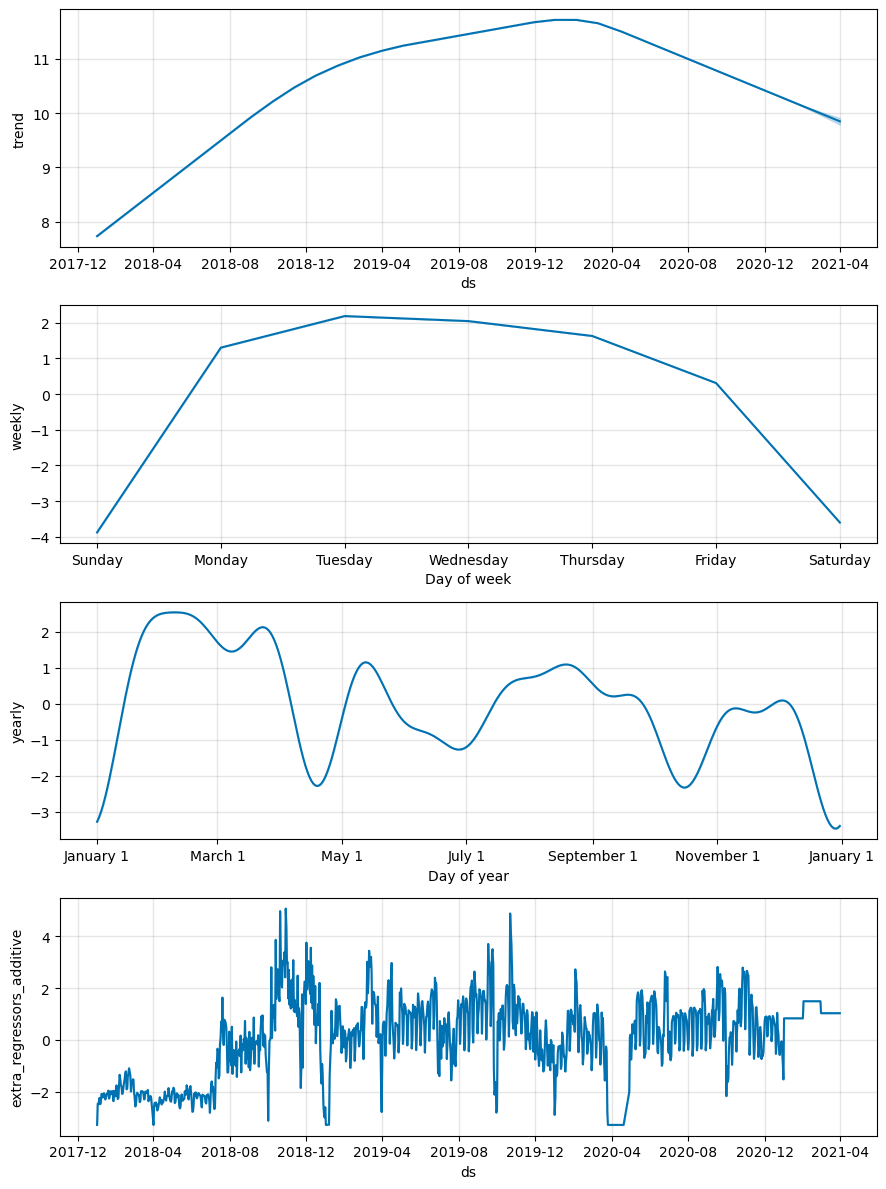

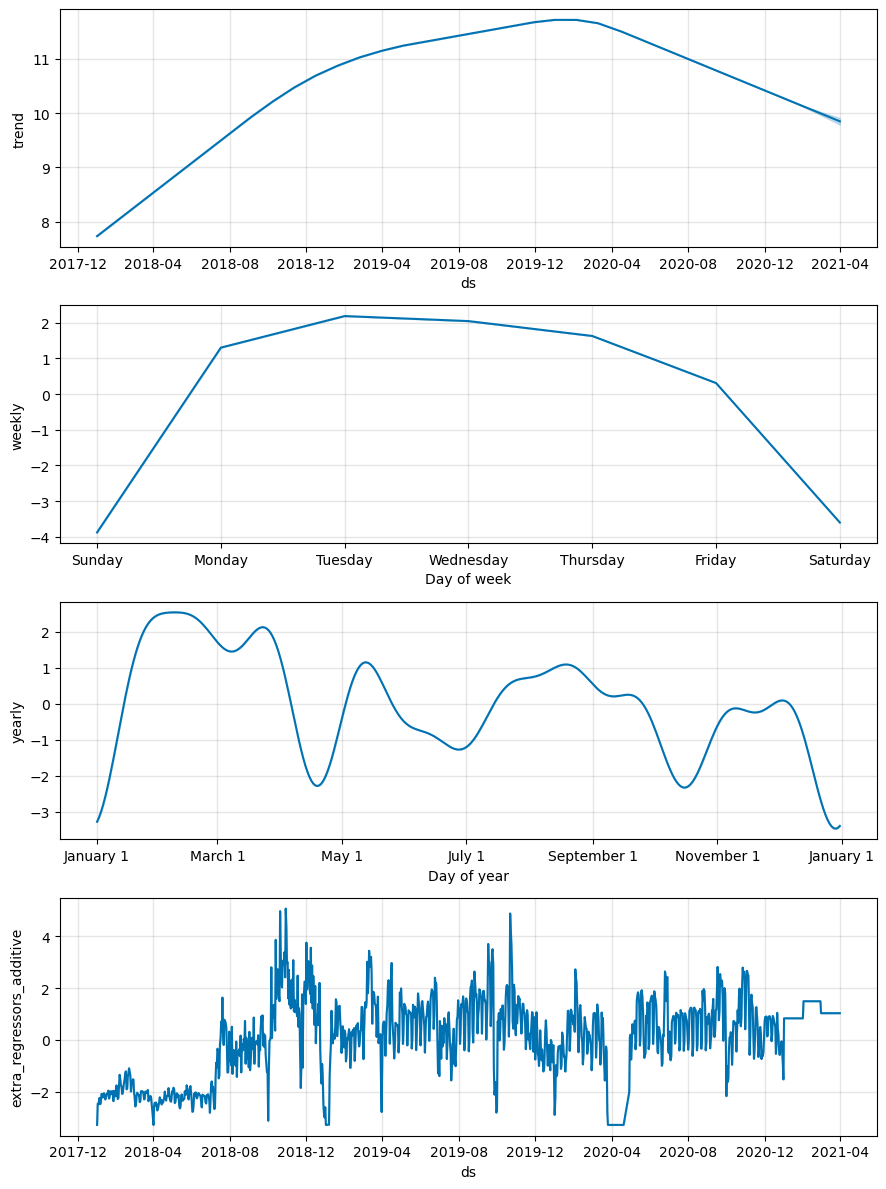

In [44]:
m.plot_components(fcst_details.loc[(fcst_details.market == 'Market 8' )& (fcst_details.forecast == 'FYQ321 - Linear')& (fcst_details.channel == 'Display')].reset_index(drop=True))

In [45]:
all_proj_inputs.loc[(all_proj_inputs.market == 'Market 8' )&(all_proj_inputs.forecast == 'FYQ321 - Linear')& (all_proj_inputs.channel == 'Display')].tail()

,forecast,market,channel,year,month,yhat,trend,spend,weekly,yearly
2951,FYQ321 - Linear,Market 8,Display,2020,11,325.669663,314.723731,19.261180,-2.574126e+00,-5.741123
2952,FYQ321 - Linear,Market 8,Display,2020,12,284.747458,320.726430,8.291196,5.862118e+00,-50.132285
2953,FYQ321 - Linear,Market 8,Display,2021,1,337.729399,316.164763,25.805125,-7.164415e+00,2.923927
2954,FYQ321 - Linear,Market 8,Display,2021,2,389.409607,281.647322,41.743194,-7.563283e-12,66.019091
2955,FYQ321 - Linear,Market 8,Display,2021,3,399.123325,307.482879,31.916301,5.535403e+00,54.188742
